# Introduction to Natural Language Processing (NLP)

---
* Rémy Frenoy
* https://www.linkedin.com/in/rfrenoy/
* https://github.com/rfrenoy
* https://github.com/rfrenoy/essec_nlp_course

---

# Disclaimer

* Lot of content in a little time
* Focus on main ideas, lot of links to best resources I know if you want to discover more.
* All content is available, at the end I'll show you how to run the code on your laptops
* Inspired from [Kaggle intro course on NLP](https://www.kaggle.com/learn/natural-language-processing) and [PyTorch tutorials on NLP](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

# Why is NLP an important Topic?

* Close relationship between language and knowledge
* Historical domain for AI (Turing test)
* Most data is textual
* Data is knowledge, data is textual, knowledge is power, so understanding text is... power

# NLP and machine learning

## What's machine learning?

Tom Mitchell: *"A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P if its performance at tasks in T, as measured by P, improves with experience E"*

* Experience E -> new data
* Class of task T -> Classification, generation, translation, ...
* Performance P -> How good the model is at doing T

The big difference between machine learning and "classical" programming is the fact that *we cannot explicitely program the rules* (it wouldn't evolve with experience *E*). So how do we find the rules?

Instead of computing a result based on a set of predefined criteria, let's say "if the flat is located in the 5th arrondissement of Paris, then its value per square meter is 13000 euros", we will construct some *"vector of criteria"* and some *"vector of weights"*, and our output will be the inner product of the two.

We will **optimize** the choice of values for our vector of weights to *minimize some cost function*, generally using [gradient descent](https://youtu.be/AeRwohPuUHQ).

## An example of regression

|    |   arrondissement |   floor |   max floor in building |   price per meter square |
|---:|-----------------:|--------:|------------------------:|-------------------------:|
|  0 |               17 |       7 |                       7 |                    11000 |
|  1 |                5 |       1 |                       7 |                    10000 |
|  2 |                3 |       4 |                       4 |                    13000 |
|  3 |               20 |       2 |                       3 |                     9500 |
|  4 |               19 |      11 |                      20 |                     8700 |
|  5 |               17 |       1 |                       6 |                     8000 |

Our model will try to find the price from the three first kinds of information. We can express our loss as some kind of difference between the predicted price and the real price, choose the loss function wisely so as to be able to compute gradient descent on it.

## What about now?

|    |   id | text                                                                                                                                  |   is real disaster? |
|---:|-----:|:--------------------------------------------------------------------------------------------------------------------------------------|--------------------:|
|  0 |    1 | Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all                                                                 |                   1 |
|  1 |    4 | Forest fire near La Ronge Sask. Canada                                                                                                |                   1 |
|  2 |    5 | All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected |                   1 |
|  3 |    6 | 13,000 people receive #wildfires evacuation orders in California                                                                      |                   1 |
|  4 |    7 | Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school                                               |                   1 |


# Data Preparation

NLP may be the domain where data preparation has the biggest impact on performance. Choices made during this phase can make the difference between a bad, a good and an excellent model. 

**Choices made during data preparation depends on the context studied.**

*Example: It is usually good practice to standardize the text and put everything in lower or upper case. But if you are trying to classify toxic comments, case carry signal, and this phase of standardization will lower your final model performances.*

## Extracting data and format it with regular expression

In [1]:
import pandas as pd
fake_operation_data = pd.read_excel('fake_operation_data.xlsx')

In [2]:
print(fake_operation_data.to_markdown())

|    | timestamp           | comment                                                                          |
|---:|:--------------------|:---------------------------------------------------------------------------------|
|  0 | 2020-01-01 00:00:00 | NTR                                                                              |
|  1 | 2020-01-02 00:00:00 | Nothing to report                                                                |
|  2 | 2020-01-03 00:00:00 | - Broke element on machine A, need to repair                                    |
|    |                     | '- Something weird going on on machine D, don't know what, should investigate 😰 |
|    |                     | '- Everything ok on other equipments                                            |


In [3]:
def sanitize_comments(raw_df):
    import re
    new_lines = []
    for i, row in raw_df.iterrows():
        # p = re.compile(r"'?\-? ?([\w | |'|,]*)", re.IGNORECASE)
        p = re.compile(r"'?\-? ?(.*)", re.IGNORECASE)
        new_line_comments = [match for match in p.findall(row.comment) 
                             if match != '']
        new_lines.append(pd.DataFrame({'timestamp': [row.timestamp] * len(new_line_comments),
                                       'comment': new_line_comments}))
    return pd.concat(new_lines)

In [4]:
cleaned_df = sanitize_comments(fake_operation_data)
print(cleaned_df.to_markdown())

|    | timestamp           | comment                                                                       |
|---:|:--------------------|:------------------------------------------------------------------------------|
|  0 | 2020-01-01 00:00:00 | NTR                                                                           |
|  0 | 2020-01-02 00:00:00 | Nothing to report                                                             |
|  0 | 2020-01-03 00:00:00 | Broke element on machine A, need to repair                                    |
|  1 | 2020-01-03 00:00:00 | Something weird going on on machine D, don't know what, should investigate 😰 |
|  2 | 2020-01-03 00:00:00 | Everything ok on other equipments                                             |


A lot of tools exist for you to quickly test your regular expressions, such as https://regex101.com/. The library documentation is available on https://docs.python.org/3/howto/regex.html.

## Tokenisation, lemmatization, stop words, ...

There are a lot of words in a vocabulary, some carrying more meaning than others. The goal of tokenisation is to separate sentences into terms. Lemmatization tries to standardize family of words to their common root to reduce the number of dimensionalities (= making the problem simpler). Stop words remove the words that appear so often that they should not carry differentiating meaning.

**Treat this with care!**

In [5]:
import spacy
nlp = spacy.load('en')

In [6]:
text = cleaned_df.comment.iloc[3]
print(text)
print('---')
doc = nlp(text)
for token in doc:
    print(token)
print()

Something weird going on on machine D, don't know what, should investigate 😰
---
Something
weird
going
on
on
machine
D
,
do
n't
know
what
,
should
investigate
😰



In [7]:
text = cleaned_df.comment.iloc[3]
print("{:>10s}\t{:>10s}\t{:>10s}\t{:>10s}".format('Token', 'Lemma', 'Stopword', 'Punctuation'))
print("-"*80)
doc = nlp(text)
for token in doc:
    print("{:>10s}\t{:>10s}\t{:>10s}\t{:>10s}".format(str(token), str(token.lemma_), str(token.is_stop), str(token.is_punct)))
print()

     Token	     Lemma	  Stopword	Punctuation
--------------------------------------------------------------------------------
 Something	 something	      True	     False
     weird	     weird	     False	     False
     going	        go	     False	     False
        on	        on	      True	     False
        on	        on	      True	     False
   machine	   machine	     False	     False
         D	         d	     False	     False
         ,	         ,	     False	      True
        do	        do	      True	     False
       n't	       not	      True	     False
      know	      know	     False	     False
      what	      what	      True	     False
         ,	         ,	     False	      True
    should	    should	      True	     False
investigate	investigate	     False	     False
         😰	         😰	     False	     False



In [8]:
for token in nlp(text):
    if not token.is_stop and not token.is_punct:
        print(token)

weird
going
machine
D
know
investigate
😰


## Emojis

A good example showing that language is a continuously-evolving domain, the use of emojis is now very common. So common that taking into account the meaning of emojis can have a tremendous impact on your model! (It depends on your context again... If you work for Doctrine, you should not see emojis that often ;-) )

In [9]:
import requests
import re

r = requests.get('https://unicode.org/Public/emoji/12.0/emoji-test.txt')
lines = r.text.split('\n')
filtered_lines = [line for line in lines if len(line) > 0 and line[0] != '#']

In [10]:
filtered_lines[:5]

['1F600                                      ; fully-qualified     # 😀 grinning face',
 '1F603                                      ; fully-qualified     # 😃 grinning face with big eyes',
 '1F604                                      ; fully-qualified     # 😄 grinning face with smiling eyes',
 '1F601                                      ; fully-qualified     # 😁 beaming face with smiling eyes',
 '1F606                                      ; fully-qualified     # 😆 grinning squinting face']

In [11]:
p = re.compile(".*# ([^\s])* (.*)")
code, meaning = zip(*[p.findall(line)[0] for line in filtered_lines])

In [12]:
my_emoji_translator = {c: meaning[i] for i,c in enumerate(code)}

In [13]:
my_emoji_translator

{'😀': 'grinning face',
 '😃': 'grinning face with big eyes',
 '😄': 'grinning face with smiling eyes',
 '😁': 'beaming face with smiling eyes',
 '😆': 'grinning squinting face',
 '😅': 'grinning face with sweat',
 '🤣': 'rolling on the floor laughing',
 '😂': 'face with tears of joy',
 '🙂': 'slightly smiling face',
 '🙃': 'upside-down face',
 '😉': 'winking face',
 '😊': 'smiling face with smiling eyes',
 '😇': 'smiling face with halo',
 '🥰': 'smiling face with hearts',
 '😍': 'smiling face with heart-eyes',
 '🤩': 'star-struck',
 '😘': 'face blowing a kiss',
 '😗': 'kissing face',
 '️': 'pirate flag',
 '☺': 'smiling face',
 '😚': 'kissing face with closed eyes',
 '😙': 'kissing face with smiling eyes',
 '😋': 'face savoring food',
 '😛': 'face with tongue',
 '😜': 'winking face with tongue',
 '🤪': 'zany face',
 '😝': 'squinting face with tongue',
 '🤑': 'money-mouth face',
 '🤗': 'hugging face',
 '🤭': 'face with hand over mouth',
 '🤫': 'shushing face',
 '🤔': 'thinking face',
 '🤐': 'zipper-mouth face',
 '🤨':

In [14]:
text = cleaned_df.comment.iloc[3]
print("{:>10s}\t{:>10s}\t{:>10s}".format('Token', 'Lemma', 'Stopword'))
print("-"*50)
doc = nlp(text)
for token in doc:
    if str(token) in my_emoji_translator:
        emoji_translation = my_emoji_translator[str(token)]
        doc_for_emoji = nlp(emoji_translation)
        for t in doc_for_emoji:
            print("{:>10s}\t{:>10s}\t{:>10s}".format(str(t), str(t.lemma_), str(t.is_stop)))

     Token	     Lemma	  Stopword
--------------------------------------------------
   anxious	   anxious	     False
      face	      face	     False
      with	      with	      True
     sweat	     sweat	     False


In [15]:
print(text)
print('-'*90)
for token in nlp(text):
    if str(token) in my_emoji_translator:
        emoji_translation = my_emoji_translator[str(token)]
        doc_for_emoji = nlp(emoji_translation)
        for t in doc_for_emoji:
            if not t.is_stop and not t.is_punct:
                print(t)
    elif not token.is_stop and not token.is_punct:
        print(token)

Something weird going on on machine D, don't know what, should investigate 😰
------------------------------------------------------------------------------------------
weird
going
machine
D
know
investigate
anxious
face
sweat


# Classification

Classification is one of the most common tasks in machine learning, and the domain of NLP is not an exception. Common classification problems in NLP are sentiment analysis, detection of spam in mail or toxic comments on forums.

More formally, the task of **classification** corresponds to trying to predict **a target that has a finite (countable) number of values.**

## Is our previous data preparation enough to directly train a classifier?

No, we have cleaned the dataset and we now have a dataset with one line per comment, such as this one

In [16]:
!pip install kaggle > /dev/null

In [17]:
!kaggle competitions download -c nlp-getting-started

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
!unzip ./nlp-getting-started.zip

Archive:  ./nlp-getting-started.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [19]:
!ls -l ./

total 4816
-rw-r--r--@ 1 remy.frenoy  staff    9047 Feb 17 17:43 fake_operation_data.xlsx
-rw-r--r--  1 remy.frenoy  staff  607343 Feb 18 13:24 nlp-getting-started.zip
-rw-r--r--  1 remy.frenoy  staff   68756 Feb 18 15:48 nlp_intro.ipynb
-rw-r--r--  1 remy.frenoy  staff  335608 Feb 18 15:40 nlp_intro.slides.html
-rw-r--r--  1 remy.frenoy  staff   22746 Dec 16 20:36 sample_submission.csv
-rw-r--r--  1 remy.frenoy  staff  420783 Dec 16 20:36 test.csv
-rw-r--r--  1 remy.frenoy  staff  987712 Dec 16 20:36 train.csv


In [20]:
import pandas as pd

full_df = pd.read_csv('train.csv')
train_df = full_df.iloc[:-1000]
test_df = full_df.iloc[-1000:]
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We said machine learning could be illustrated by learning a vector of weights that will multiply a vector of features. For this to work, our vector of features must contain numerical values. We have to convert our text data to numerical data in some way. The most basic way to do it is to use the **Bag of Words** representation.

In Bag of Words (BoW), we will create a matrix with as many columns as we have words in our vocabulary. Each line in the matrix will represent a text, and we will simply put a binary value indicating whether the text contains a given word or not.

Do you see a limitation with this approach?

* A lot of columns!

* Representation of a text only by the words in it: no representation of the order of the words. _"Tom loves maths"_ and _"Maths love Tom"_ have the same representation, while the two sentences do not have the same meaning.

Some approaches improve BoW representation but keep the same idea: Term Frequency (TF) and Term Frequency-Inverse Document Frequency (TF-IDF) use floating values instead of binary values, representing the ratio between the number of occurences of the word in the text and the number of occurences of the word in the whole corpus.

Instead of using a column per word, it is possible to use group of words (or group of letters in some contexts). These are called N-grams (N being the cardinality of the group). Mostly bigrams and trigrams are used. It allows for a shallow representation of neighborhood but increase dramatically the number of columns, which is an issue (See the curse of dimensionality)

In [21]:
import spacy

# Create an empty model
nlp = spacy.blank("en")

# Create the TextCategorizer with exclusive classes and "bow" architecture
textcat = nlp.create_pipe(
              "textcat",
              config={
                "exclusive_classes": True,
                "architecture": "bow"})

# Add the TextCategorizer to the empty model
nlp.add_pipe(textcat)

In [22]:
# Add labels to text classifier
textcat.add_label('no_disaster')
textcat.add_label('disaster')

1

In [23]:
train_texts = train_df['text'].values
train_labels = [{'cats': {'disaster': label == 1,
                          'no_disaster': label == 0}} 
                for label in train_df['target']]

In [24]:
train_data = list(zip(train_texts, train_labels))
train_data[:3]

[('Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
  {'cats': {'disaster': True, 'no_disaster': False}}),
 ('Forest fire near La Ronge Sask. Canada',
  {'cats': {'disaster': True, 'no_disaster': False}}),
 ("All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
  {'cats': {'disaster': True, 'no_disaster': False}})]

In [26]:
import random
from spacy.util import minibatch

random.seed(1)
spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

losses = {}
for epoch in range(20):
    random.shuffle(train_data)
    # Create the batch generator with batch size = 8
    batches = minibatch(train_data, size=8)
    # Iterate through minibatches
    for batch in batches:
        # Each batch is a list of (text, label) but we need to
        # send separate lists for texts and labels to update().
        # This is a quick way to split a list of tuples into lists
        texts, labels = zip(*batch)
        nlp.update(texts, labels, sgd=optimizer, losses=losses)
    print(losses)

{'textcat': 4.75042068969924}
{'textcat': 7.534200280497316}
{'textcat': 9.428553090867354}
{'textcat': 10.817569403530797}
{'textcat': 11.857005193585792}
{'textcat': 12.684824872467289}
{'textcat': 13.348254462805926}
{'textcat': 13.903660962851063}
{'textcat': 14.370522920558642}
{'textcat': 14.761760743025206}
{'textcat': 15.098512723614022}
{'textcat': 15.390464223343656}
{'textcat': 15.644695843835024}
{'textcat': 15.870631646182474}
{'textcat': 16.074076384343968}
{'textcat': 16.262207440632935}
{'textcat': 16.429086710450996}
{'textcat': 16.5857346500268}
{'textcat': 16.729227058711775}
{'textcat': 16.865232349534388}


In [27]:
texts = ["Just happened a terrible car crash",
         "I like potatoes",
         "I am eating potatoes in a wild fire"]
docs = [nlp.tokenizer(text) for text in texts]
    
# Use textcat to get the scores for each doc
textcat = nlp.get_pipe('textcat')
scores, _ = textcat.predict(docs)

print(scores)

[[0.49625212 0.5037479 ]
 [0.644427   0.35557306]
 [0.6178041  0.3821959 ]]


In [28]:
docs = [nlp.tokenizer(text) for text in test_df.text]
    
# Use textcat to get the scores for each doc
textcat = nlp.get_pipe('textcat')
scores, _ = textcat.predict(docs)

print(scores)

[[4.9454351e-03 9.9505460e-01]
 [8.1476718e-01 1.8523285e-01]
 [9.9718082e-01 2.8191626e-03]
 ...
 [1.1868637e-01 8.8131356e-01]
 [2.8035771e-03 9.9719644e-01]
 [4.3218108e-05 9.9995673e-01]]


In [29]:
import numpy as np
preds = np.argmax(scores, axis=1)
good_preds = preds == test_df.target.values
print(good_preds.sum()/len(preds))

0.732


An entirely different approach is to use **word embeddings**. Words embeddings relate to the task of _dimensionality reduction_, which means that we try to compress the information in lower dimensions than the initial space. Initially, if we have a vocabulary with 5000 words, we have 5000 dimensions (=5000 columns in our BoW representation). We can try to encode our words in a 10-dimensional space

In [31]:
import numpy as np
import spacy

# Need to load the large model to get the vectors
nlp = spacy.load('en_core_web_lg')
with nlp.disable_pipes():
    train_vectors = np.array([nlp(text).vector for text in train_df.text])
    test_vectors = np.array([nlp(text).vector for text in test_df.text])
    
print(train_vectors.shape)
print(test_vectors.shape)

(6613, 300)
(1000, 300)


In [32]:
from sklearn.svm import LinearSVC

svc = LinearSVC(random_state=1, dual=False, max_iter=10000)
svc.fit(train_vectors, train_df.target)
print(f"Accuracy: {svc.score(test_vectors, test_df.target) * 100:.3f}%", )

Accuracy: 79.200%


# Generation

Text generation can have a lot of applications:
* Chatbots
* Data to text (meeting summary)
* Joke generators!

<img src="gen_model_archi.png" width="600">

![Model architecture](gen_model_target.png "Target")

In [1]:
!curl https://download.pytorch.org/tutorial/data.zip --output data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  3570k      0 --:--:-- --:--:-- --:--:-- 3571k


In [3]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


In [8]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [9]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [10]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [11]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [12]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [13]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [14]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 18s (5000 5%) 2.5928
0m 36s (10000 10%) 2.8660
0m 53s (15000 15%) 3.5749
1m 10s (20000 20%) 3.2637
1m 28s (25000 25%) 2.8026
1m 46s (30000 30%) 3.0794
2m 3s (35000 35%) 2.3518
2m 21s (40000 40%) 2.0979
2m 38s (45000 45%) 1.9484
2m 56s (50000 50%) 2.5137
3m 14s (55000 55%) 2.6974
3m 32s (60000 60%) 2.9802
3m 50s (65000 65%) 2.4425
4m 8s (70000 70%) 2.3670
4m 26s (75000 75%) 1.6408
4m 44s (80000 80%) 2.5503
5m 2s (85000 85%) 2.8913
5m 19s (90000 90%) 2.0961
5m 36s (95000 95%) 3.0738
5m 53s (100000 100%) 2.4669


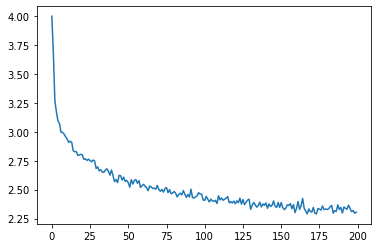

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [18]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [20]:
samples('Russian', 'RUS')

Rovellov
Uarishin
Shallovov


In [22]:
samples('German', 'GER')

Ganter
Erenter
Rone


In [24]:
samples('Spanish', 'SPA')

Santa
Parier
Allan


In [25]:
samples('Chinese', 'CHI')

Chan
Han
Iun


In [60]:
samples('French', 'ADG')

Arter
Deller
Garere


# Translation

In [62]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [63]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [64]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [65]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [66]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [67]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['elle lui est apparentee par alliance .', 'she is related to him by marriage .']


In [68]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [69]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [70]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [71]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [72]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [73]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [74]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [75]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [76]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [77]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

3m 54s (- 54m 45s) (5000 6%) 2.8304
8m 9s (- 53m 0s) (10000 13%) 2.2767
12m 14s (- 48m 59s) (15000 20%) 1.9638
16m 30s (- 45m 23s) (20000 26%) 1.7347
20m 58s (- 41m 56s) (25000 33%) 1.5058
25m 12s (- 37m 49s) (30000 40%) 1.3611
29m 29s (- 33m 42s) (35000 46%) 1.2166
33m 17s (- 29m 7s) (40000 53%) 1.0626
37m 4s (- 24m 42s) (45000 60%) 0.9901
40m 48s (- 20m 24s) (50000 66%) 0.8771
44m 38s (- 16m 13s) (55000 73%) 0.7956
48m 27s (- 12m 6s) (60000 80%) 0.7203
52m 11s (- 8m 1s) (65000 86%) 0.6642
55m 59s (- 3m 59s) (70000 93%) 0.6056
59m 51s (- 0m 0s) (75000 100%) 0.5438


<Figure size 432x288 with 0 Axes>

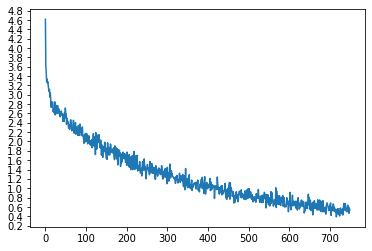

In [78]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [79]:
evaluateRandomly(encoder1, attn_decoder1)

> nous sommes prets desormais .
= we re ready now .
< we re ready now . <EOS>

> je suis electricien .
= i am an electrician .
< i am an electrician . <EOS>

> tu es plus grand que moi .
= you re taller than i am .
< you re taller than i . <EOS>

> ce sont mes amis .
= they are my friends .
< they re my friends . <EOS>

> vous ne convenez pas .
= you re not fit .
< you re not following . <EOS>

> ce n est pas mon cousin .
= he s not my cousin .
< he s not my my . <EOS>

> je suis ravi de faire votre connaissance .
= i m very pleased to meet you .
< i m pleased to meet you from . <EOS>

> vous etes une personne merveilleuse .
= you re a wonderful guy .
< you re a wonderful guy . <EOS>

> il n est plus tout jeune .
= he s not young anymore .
< he is not young anymore . <EOS>

> il a des ennuis .
= he is in trouble .
< he is in trouble . <EOS>



In [94]:
output_words, attentions = evaluate(encoder1, attn_decoder1, 'j ai fini')
' '.join(output_words)

'i m done . <EOS>'

In [96]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


/Users/remy.frenoy/Dev/BBL/essec_nlp_course/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


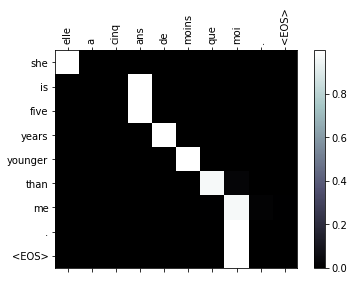

In [97]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

# Conclusion and take aways

* NLP is a whole domain in the machine learning spectrum
* The domain has its own challenges, mostly around the best way to numerically represent language
* Be careful with the way you handle data, you can easily make performances drop with a single bad choice
* Test your model for potential biases, see [Jigsaw Kaggle competition](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification)